In [1]:
from Tools.Tokenizer.tokenizer import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [2]:
stop_words = set(stopwords.words('armenian')) 

# Helpers
def tokenize(text):
    T = Tokenizer(text)
    T.segmentation().tokenization()
    word_tokens = []
    for segment in T.segments:
        for token in segment['tokens']:
            word_tokens.append(token[1].lower())
    return word_tokens

def remove_stopwords(word_tokens):
    filtered_word_tokens = [w for w in word_tokens if not w in stop_words]
    return filtered_word_tokens

def stemming(word_tokens):
    stemmer = SnowballStemmer("armenian") 
    filtered_word_tokens = [ stemmer.stem(w) for w in word_tokens ]
    return filtered_word_tokens

In [3]:
import pandas as pd
import nltk

# graphics
import matplotlib.pyplot as plt 
import seaborn as sns

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

# LabelPowerset
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset

In [4]:
# Load Training data
df = pd.read_csv('data/clean/Trainning_reviews.csv')
initial_df = pd.read_csv('data/clean/Trainning_reviews.csv')

# cleaning up text
df['Description'] = df['Description'].apply(lambda row : row + '։') 
df['Description'] = df['Description'].apply(tokenize)

df['Description'] = df['Description'].apply(remove_stopwords)
df['Description'] = df['Description'].apply(stemming)
df['Description'] = df['Description'].apply(lambda row : ' '.join(row)) 

df.rename(columns = {'Symptoms':'symptom_list'}, inplace = True) 

In [5]:
# extract symptoms
symptoms = [] 

for i in df['symptom_list']: 
    symptoms.append(i.split(', ')) 
# add to  dataframe  
df['Symptoms'] = symptoms

In [6]:
# get all symptom tags in a list
all_symptoms = sum(symptoms,[])

In [7]:
all_symptoms = nltk.FreqDist(all_symptoms) 
# create dataframe
all_symptoms_df = pd.DataFrame({'Symtom': list(all_symptoms.keys()), 
'Count': list(all_symptoms.values())})

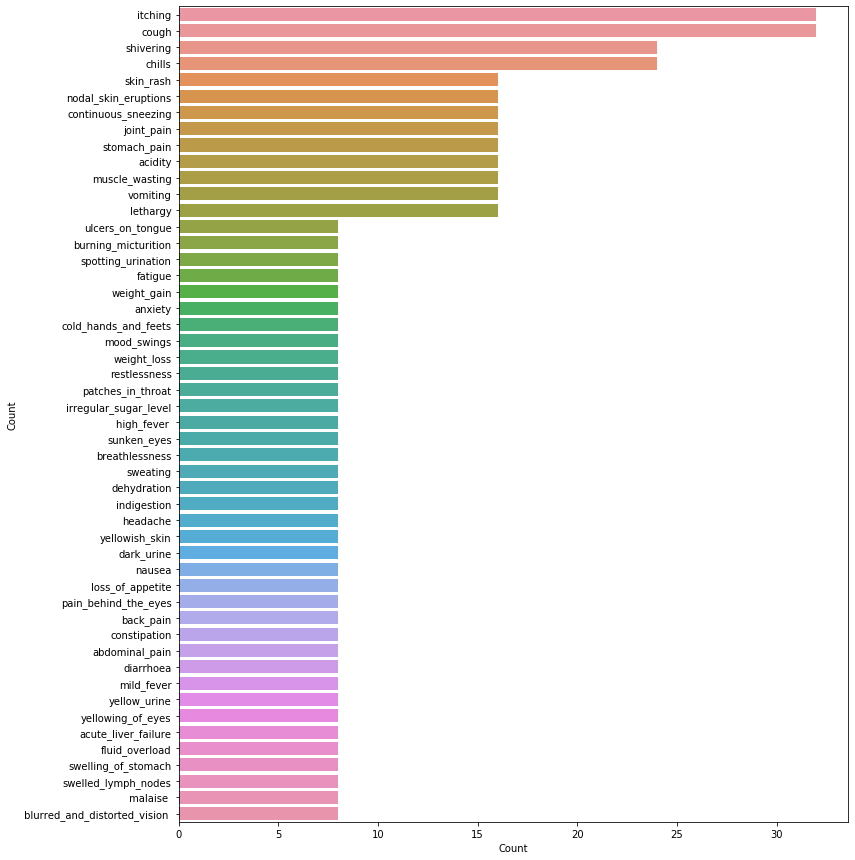

In [8]:
g = all_symptoms_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Symtom") 
ax.set(ylabel = 'Count') 
plt.show()

In [9]:
# Vectorization
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['Symptoms'])
# transform target variable
y = multilabel_binarizer.transform(df['Symptoms'])

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [11]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(df['Description'], y, test_size=0.2, random_state=9)

In [12]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [13]:
# Label Powerset
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(xtrain_tfidf, ytrain)
lp_predictions = lp_classifier.predict(xval_tfidf)
print("Accuracy = ",accuracy_score(yval,lp_predictions))
print("F1 score = ",f1_score(yval,lp_predictions, average="micro"))
print("Hamming loss = ",hamming_loss(yval,lp_predictions))

Accuracy =  0.9605263157894737
F1 score =  0.9645669291338582
Hamming loss =  0.0005762581636573184


In [14]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])

    q_pred = lp_classifier.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [15]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Կարծիք: ", initial_df['Description'][k])
    print("Կանխատեսում: ", infer_tags(xval[k]))
    print("Իրականություն: ",df['Symptoms'][k], "\n")

Կարծիք:  մարսողություն 
Կանխատեսում:  [('indigestion',)]
Իրականություն:  ['indigestion'] 

Կարծիք:  թաց փռշտոց
Կանխատեսում:  [(' mucoid_sputum ',)]
Իրականություն:  [' mucoid_sputum '] 

Կարծիք:  մկանների թուլություն 
Կանխատեսում:  [('muscle_wasting',)]
Իրականություն:  [' muscle_weakness '] 

Կարծիք:  որովայնային ցավ, փորացավ, փորի ցավ
Կանխատեսում:  [(' belly_pain ',)]
Իրականություն:  ['abdominal_pain'] 

Կարծիք:  ֆլեգմա. լորձ, խորխ
Կանխատեսում:  [(' phlegm ',)]
Իրականություն:  [' phlegm '] 



t = 0.05
Ճշգրտություն =  0.8508771929824561
F1 =  0.9321100917431193
Մուրճի կորուստ =  0.0011845306697400436
t = 0.06
Ճշգրտություն =  0.8728070175438597
F1 =  0.9407407407407408
Մուրճի կորուստ =  0.0010244589576130106
t = 0.07
Ճշգրտություն =  0.9166666666666666
F1 =  0.9584905660377357
Մուրճի կորուստ =  0.0007043155333589449
t = 0.08
Ճշգրտություն =  0.8947368421052632
F1 =  0.9485714285714286
Մուրճի կորուստ =  0.0008643872454859777
t = 0.09
Ճշգրտություն =  0.9035087719298246
F1 =  0.9558541266794627
Մուրճի կորուստ =  0.0007363298757843514
t = 0.1
Ճշգրտություն =  0.9035087719298246
F1 =  0.9558541266794627
Մուրճի կորուստ =  0.0007363298757843514
t = 0.11
Ճշգրտություն =  0.9122807017543859
F1 =  0.9613899613899614
Մուրճի կորուստ =  0.0006402868485081316
t = 0.12
Ճշգրտություն =  0.9210526315789473
F1 =  0.9590643274853801
Մուրճի կորուստ =  0.0006723011909335382
t = 0.13
Ճշգրտություն =  0.9210526315789473
F1 =  0.9590643274853801
Մուրճի կորուստ =  0.0006723011909335382
t = 0.14
Ճշգրտությու

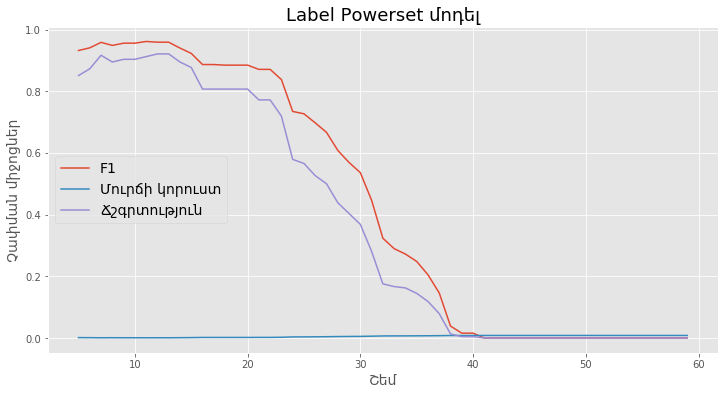

In [16]:
#for plotting metrics as a function of threashold

# predict probabilities
y_pred_prob = lp_classifier.predict_proba(xval_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

th = []
f = []
ham = []
ac = []
for t in range (5,60): # threshold value
    y_pred_new = (y_pred_prob >= t/100).astype(int)
    print("t =" ,t/100)
    print("Ճշգրտություն = ",accuracy_score(yval,y_pred_new))
    print("F1 = ",f1_score(yval,y_pred_new, average="micro"))
    print("Մուրճի կորուստ = ",hamming_loss(yval,y_pred_new))
    th.append(t)
    ac.append(accuracy_score(yval,y_pred_new))
    f.append(f1_score(yval,y_pred_new, average="micro"))
    ham.append(hamming_loss(yval,y_pred_new))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
     plt.plot(th, f)
     plt.plot(th, ham)
     plt.plot(th, ac)
     plt.legend(['F1', 'Մուրճի կորուստ', 'Ճշգրտություն'], loc='center left', fontsize = 14)
     plt.ylabel("Չափման միջոցներ", fontsize = 14)
     plt.xlabel("Շեմ", fontsize = 14)
     plt.title("Label Powerset մոդել", fontsize = 18)
plt.show()